In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pykospacing import Spacing
from kiwipiepy import Kiwi
import re
from collections import Counter
import random
from math import pi
import warnings
warnings.filterwarnings("ignore")

In [2]:
plt.rcParams['font.family'] = 'Malgun Gothic'

In [3]:
pd.set_option('display.max_colwidth', None)

In [4]:
df = pd.read_json("./data/converted_Labeled_reviews(JJINMAK).jsonl", lines = True)

# 샘플 db 용 데이터프레임 만들기

- 무시해도 됩니다!!!

In [5]:
def extract_labels(annotation):
    pair_lst = []
    aspect_lst = []
    for i in range(0, len(annotation)):
        aspect = annotation[i][0]
        polarity = annotation[i][2]
        
        if aspect not in aspect_lst:
            aspect_lst.append(aspect)
            pair_lst.append((aspect, polarity))

    return pair_lst

In [6]:
df["labels"] = df["annotation"].map(extract_labels)

In [7]:
temp_name = [
    '레몬 샴푸 520mL 2입, 퍼퓸 샴푸 520mL 2입 중 택 1',
    '가려운 두피케어샴푸 520mL 2입 기획, 쿨멘솔 520mL 2입 기획 중 택 1',
    '프리미엄 샴푸 (본품300g+6gx5매 추가 증정)',
    '모이스처 샴푸 모로칸 가드너 300ml',
    '가려운 두피케어 샴푸 850ml',
    'BD샴푸 500g',
    '프로페셔널 오일컨트롤 샴푸 300ml',
    '헤어리프팅 샴푸 엑스트라 스트롱 475ml (단품/증정기획)'         
            ]

In [8]:
df["name"] =  random.choices(temp_name, k = len(df))

In [5]:
df.head()

,sentence_form,annotation
0,바오밥 신제품 나와서 사봤어요 시카라인이라서 그런지 두피세정이 잘 되는 느낌이에요,"[[세정, [두피세정이 잘 되는 느낌이에요, 29, 45], positive]]"
1,이렇게 예쁜 샴푸는 처음이야종류도 다양하고 저는 탈모샴푸로 비컨피던트 구매해 봤는데 감을 때 시원하고 향도 시원해서 여름에 사용하기 참좋더라구요 향기 좋고 세정력 좋은 샴푸로 추천합니다,"[[세정, [시원하고, 52, 56], positive], [향, [향도 시원해서, 57, 64], positive], [향, [향기 좋고, 81, 86], positive], [세정, [세정력 좋은 샴푸, 87, 96], positive]]"
2,"케이스부터 고급지네요지루성두피염이라 아무거나 못쓰는 편이라신중히 고르는 편이예요노모어오일이 조금 더 비싸서 좋지 않을까 했는데오일샴푸라 린언미로 겟했어요그런데 딱 원하는 제품이네요뾰루지가 잘 나는 두피인데 염증 완화에 도움을준데요합성계면 활성제, 합성 방부제 없고 그외에도 전제품 EWG 98프로 이상 유해성분 제외라고하니믿고 써봅니다향이 시원한 느낌이고 거품도 잘나며 개운한느낌입니다","[[향, [향이 시원한 느낌이고, 187, 198], positive], [거품, [거품도 잘나며, 199, 206], positive], [세정, [개운한느낌입니다, 207, 215], positive]]"
3,좋아요.리필팩도 들어있어서원플러스 원처럼 구입하게 되서 좋아요.,"[[가격, [원플러스 원처럼 구입하게 되서 좋아요, 14, 34], positive]]"
4,샴푸를 잘못 구매하면 머리가 떡지거나 거품이 잘안나거나 샴푸후 머리가 푸석해져서 몹시 까다로운편인데이건 가격도 합리적이고 향도 매우좋은 로즈향?같이 나서 샴푸할때마다 기분이 너무 좋아요 또 거품도 쫀쫀하게 나고 하고나서 세정력도 좋아요! 샴푸후 푸석거림도 없습니다영양까지는 모르겠지만 기본으로 적당한 샴푸 찾으시면 무난히 성공합니다,"[[가격, [가격도 합리적이고, 58, 67], positive], [향, [향도 매우좋은, 68, 75], positive], [거품, [거품도 쫀쫀하게, 106, 114], positive], [세정, [세정력도 좋아요, 123, 131], positive], [머릿결, [푸석거림도 없습니다, 137, 147], positive]]"


In [10]:
# DB 에 들어갈 형식으로 변환
db_data = []
for i in range(0, len(df)):
    sentence_form = df.loc[i, "sentence_form"]
    name = df.loc[i, "name"]
    for aspect, sentiment in df.loc[i, "labels"]:
        db_data.append({
            "name" : name,
            "sentence" : sentence_form,
            "aspect" : aspect,
            "sentiment" : sentiment
        })
db_df = pd.DataFrame(db_data)

In [11]:
# df의 라벨 수와 db용 df의 길이 비교
db_df.shape[0] == df["labels"].map(lambda x: len(x)).sum()

True

In [12]:
# db_df 는 크롤링한 전체 데이터에 레이블 열이 추가된 데이터프레임
# grouped 는 AspectSentiment 테이블을 생성하기 위해 name (제품명) 을 기준으로 그룹화
grouped = db_df.groupby(["name"], observed = True)

In [13]:
def count_pairs(gp):
    count_dict = {pair : 0 for pair in pair_labels}
    for aspect, sentiment in gp[["aspect", "sentiment"]].values:
        for pair in pair_labels:
            if aspect == pair[0] and sentiment == pair[1]:
                count_dict[pair] += 1
                break

    return count_dict

In [14]:
def compute_ratio(gp_df):
    total = gp_df.groupby("aspect")["count"].sum()
    gp_df["total"] = gp_df["aspect"].map(lambda x: total[x])
    gp_df["ratio"] = gp_df.apply(
        lambda x: round(x['count'] / x['total'], 4) if x['total'] != 0 else 0,
        axis=1
    )
    return gp_df

In [20]:
entity_name = [
    '세정', '자극', '거품', '향', '가격', '머릿결', '탈모', '쿨링'
]
polarity_name = [
    'positive', 'neutral', 'negative'
]
pair_labels = [(entity, polarity) for polarity in polarity_name for entity in entity_name]
pair_labels.append(('없음', '-'))

In [21]:
# 종합해서 전체 데이터프레임 생성
gp_keys = list(grouped.groups.keys())
db_df = pd.DataFrame(columns=['name', 'aspect', 'sentiment', 'total', 'ratio'])

for key in gp_keys:
    gp = grouped.get_group((key))
    count_dict = count_pairs(gp)
    gp_df = pd.Series(count_dict).reset_index()
    gp_df.columns = ['aspect', 'sentiment', 'count']
    gp_df = gp_df.sort_values(by="aspect")
    gp_df = compute_ratio(gp_df)
    gp_df["name"] = [key] * len(gp_df)

    db_df = pd.concat([db_df, gp_df], axis = 0)

In [22]:
db_df.head()

,name,aspect,sentiment,total,ratio,count
12,BD샴푸 500g,가격,neutral,33,0.0303,1.0
20,BD샴푸 500g,가격,negative,33,0.1818,6.0
4,BD샴푸 500g,가격,positive,33,0.7879,26.0
2,BD샴푸 500g,거품,positive,105,0.8286,87.0
18,BD샴푸 500g,거품,negative,105,0.1143,12.0


In [23]:
db_df.shape

(200, 6)

# 제품명 + 속성 검색

- name 대신 shampoo_id

In [ ]:
# views.py
# 제품명 검색
def sort_searched_items(request):
    # 사용자 입력
    searched_name = request.GET.get('name', '')
    preferred_aspect = request.GET.getlist('aspect')  # 복수 선택 

    # 필터링
    filtered = AspectSentiment.objects.filter(
                    name__icontains=searched_name,
                    aspect__in=preferred_aspect,
                    sentiment='positive'
                )
    
    # name 별 평균 ratio 기준 내림차순
    ordered = filtered.values('name').annotate(avg_ratio=Avg('ratio')).order_by('-avg_ratio')  

    # 정렬된 name 리스트 추출
    ordered_names = [item['name'] for item in ordered]

    # Shampoo 객체들을 가져오기
    shampoos = Shampoo.objects.filter(name__in=ordered_names)

    # 딕셔너리로 이름: 객체 매칭 후 순서대로 재정렬
    shampoos_map = {shampoo.name: shampoo for shampoo in shampoos}
    sorted_shampoos = [shampoos_map[name] for name in ordered_names if name in shampoos_map]

    
    context = {
        'sorted_shampoos': sorted_shampoos,
        'search_name': search_name,
        'preferred_aspect': preferred_aspect,
    }

    return render(request, 'main_page.html', context)

# 브랜드 + 속성 검색

- name 대신 shampoo_id

In [ ]:
# views.py
# 브랜드 검색
def sort_searched_brand(request):
    # 사용자 입력
    searched_brand = request.GET.get('brand', '')
    preferred_aspect = request.GET.getlist('aspect')  # 복수 선택 

    # 필터링
    shampoos = Shampoo.objects.filter(
                    brand__icontains=searched_brand
                )
      
    # 브랜드 기준으로 추출된 제품명
    brand_filtered_names = shampoos.values_list('name', flat=True)

    # AspectSentiment 필터링
    filtered = AspectSentiment.objects.filter(
        name__in=brand_filtered_names,  # 브랜드 필터된 것만 사용
        aspect__in=preferred_aspect,
        sentiment='positive'
    )

    # name 별 평균 ratio 기준 내림차순
    ordered = filtered.values('name').annotate(avg_ratio=Avg('ratio')).order_by('-avg_ratio')

    # 정렬된 name 리스트 추출
    ordered_names = [item['name'] for item in ordered]

    # Shampoo 객체들을 가져오기
    shampoos = Shampoo.objects.filter(name__in=ordered_names)
    
    # 딕셔너리로 이름: 객체 매칭 후 순서대로 재정렬
    shampoos_map = {shampoo.name: shampoo for shampoo in shampoos}
    sorted_shampoos = [shampoos_map[name] for name in ordered_names if name in shampoos_map]

    context = {
        'sorted_shampoos': sorted_shampoos,
        'search_brand': search_brand,
        'preferred_aspect': preferred_aspect,
    }

    return render(request, 'main_page.html', context)

# 상품별 종합 리뷰 분석

- 속성별 감성 막대 쌓기

- 속성별 해당 속성이 언급된 비율
    - 도넛차트
 
- 속성별 감성 점수
    - 긍정ratio * 2 + 중립ratio * 1 + 부정ratio * 0
    - 방사형차트 (언급된 리뷰 수로 정렬해서 top5 속성에 대해)

## 속성별 감성 막대 쌓기

In [24]:
name = "BD샴푸 500g"
data = db_df[(db_df["name"] == name) & (db_df["aspect"] != "없음")]
pivot_df = data.pivot(index='aspect', columns='sentiment', values='count')
pivot_df = pivot_df[['positive', 'neutral', 'negative']]
pivot_df

sentiment,positive,neutral,negative
aspect,,,
가격,26.0,1.0,6.0
거품,87.0,6.0,12.0
머릿결,38.0,5.0,13.0
세정,103.0,1.0,10.0
자극,34.0,0.0,2.0
쿨링,6.0,0.0,0.0
탈모,12.0,3.0,3.0
향,102.0,10.0,9.0


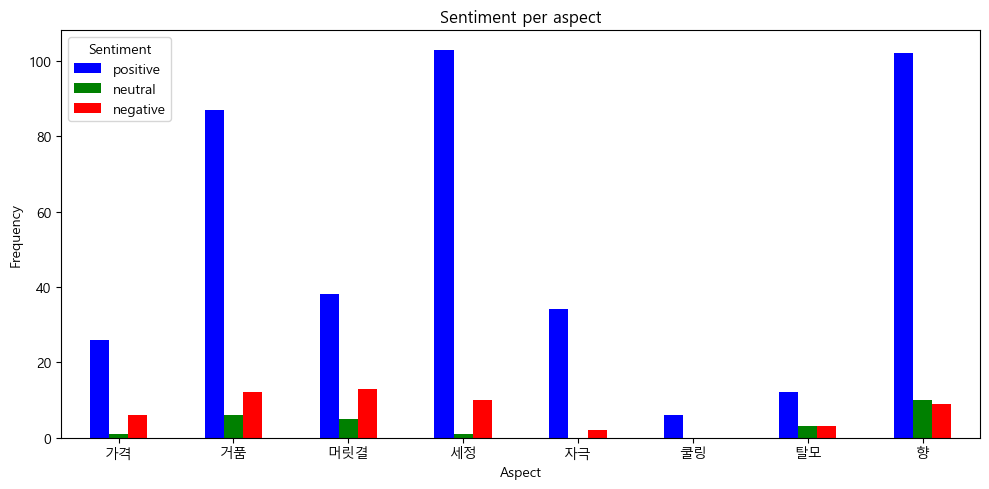

In [31]:
# 시각화
fig, ax = plt.subplots(figsize=(10, 5)) 

pivot_df.plot(kind='bar', color=['blue', 'green', 'red'], ax = ax)

plt.title('Sentiment per aspect')
plt.xlabel('Aspect')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.legend(title='Sentiment')
plt.tight_layout()

plt.show()

## 속성별 해당 속성이 언급된 비율

In [32]:
total_per_aspect = db_df.groupby(["name", "aspect"])["total"].mean()
total_per_aspect

name                               aspect
BD샴푸 500g                          가격         33.0
                                   거품        105.0
                                   머릿결        56.0
                                   세정        114.0
                                   없음          0.0
                                             ...  
헤어리프팅 샴푸 엑스트라 스트롱 475ml (단품/증정기획)  없음          0.0
                                   자극         29.0
                                   쿨링          4.0
                                   탈모         16.0
                                   향          95.0
Name: total, Length: 72, dtype: object

In [35]:
name = "BD샴푸 500g"
data = total_per_aspect[name]
# 0 인 데이터 제거
data = data[data > 0]

# 특정 비율 미만인 항목 필터링해서 기타로 묶기
ratio = 0.05
threshold = data.sum() * ratio
others = data[data < threshold]
graph_data = data[data >= threshold]

if not others.empty:
     graph_data["기타"] = others.sum()

# 내림차순 정렬
graph_data = graph_data.sort_values(ascending = False)


graph_data.index, graph_data.values

(Index(['향', '세정', '거품', '머릿결', '자극', '가격', '기타'], dtype='object', name='aspect'),
 array([121.0, 114.0, 105.0, 56.0, 36.0, 33.0, 24.0], dtype=object))

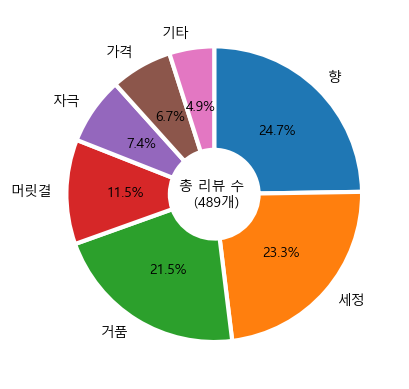

In [36]:
count = graph_data.values
labels = graph_data.index

wedgeprops = {"width" : 0.7, "edgecolor" : "w", "linewidth" : 3} # 차트 형태 옵션

plt.pie(count, labels = labels, autopct = "%.1f%%", startangle = 90, counterclock = False,
        wedgeprops = wedgeprops) 

plt.text(0, 0, f"총 리뷰 수 \n ({round(graph_data.values.sum())}개)", ha = "center", va = "center")

plt.show()

## 속성별 감성 점수

In [37]:
name = "BD샴푸 500g"
data = db_df[(db_df["name"] == name) & (db_df["aspect"] != "없음")]
data.head()

,name,aspect,sentiment,total,ratio,count
12,BD샴푸 500g,가격,neutral,33,0.0303,1.0
20,BD샴푸 500g,가격,negative,33,0.1818,6.0
4,BD샴푸 500g,가격,positive,33,0.7879,26.0
2,BD샴푸 500g,거품,positive,105,0.8286,87.0
18,BD샴푸 500g,거품,negative,105,0.1143,12.0


In [39]:
# total 기준으로 top6 속성만 뽑기
filtered_aspect = data.groupby("aspect")["total"].mean().sort_values(ascending = False).index[:6]
filtered_data = data[data["aspect"].isin(filtered_aspect)]
filtered_data

,name,aspect,sentiment,total,ratio,count
12,BD샴푸 500g,가격,neutral,33,0.0303,1.0
20,BD샴푸 500g,가격,negative,33,0.1818,6.0
4,BD샴푸 500g,가격,positive,33,0.7879,26.0
2,BD샴푸 500g,거품,positive,105,0.8286,87.0
18,BD샴푸 500g,거품,negative,105,0.1143,12.0
10,BD샴푸 500g,거품,neutral,105,0.0571,6.0
21,BD샴푸 500g,머릿결,negative,56,0.2321,13.0
5,BD샴푸 500g,머릿결,positive,56,0.6786,38.0
13,BD샴푸 500g,머릿결,neutral,56,0.0893,5.0
16,BD샴푸 500g,세정,negative,114,0.0877,10.0


In [41]:
def compute_sentiment_score(x):
    result = x.loc[x["sentiment"] == "positive", "ratio"].sum() * 2 \
            + x.loc[x["sentiment"] == "neutral", "ratio"].sum() * 1 \
            + x.loc[x["sentiment"] == "negative", "ratio"].sum() * 0
    return result
    
sentiment_score = filtered_data.groupby("aspect")[["sentiment", "ratio"]].apply(compute_sentiment_score)

In [43]:
# 방사형 차트에서 속성 간 차이 시각화를 위해 제곱
squared = sentiment_score ** 2
sentiment_score = squared / squared.max()
center = 0

In [44]:
sentiment_score

aspect
가격     0.723058
거품     0.823762
머릿결    0.586496
세정     0.924196
자극     1.000000
향      0.876773
dtype: float64

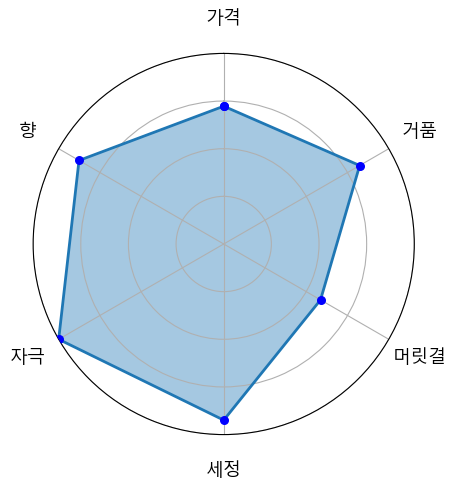

In [45]:
# 방사형 차트 - 하나씩 시각화

labels = sentiment_score.index
num_labels = len(labels)


# 등분점 생성    
angles = [x/float(num_labels)*(2*pi) for x in range(num_labels)]
angles += angles[:1] # 시작점 생성
   
 
fig = plt.figure(figsize=(5, 5))
fig.set_facecolor('white')
 
data = list(sentiment_score.values)
data += data[:1]

ax = plt.subplot(1,1,1, polar=True)
# 시작점 설정
ax.set_theta_offset(pi / 2)
# 시계방향 설정
ax.set_theta_direction(-1)

# 각도 축 눈금 생성
plt.xticks(angles[:-1], labels, fontsize=13)
# 각 축과 눈금 사이 여백생성
ax.tick_params(axis='x', which='major', pad=15)
# 반지름 축 눈금 라벨 각도 0으로 설정
ax.set_rlabel_position(0)
# 반지름 축 눈금 설정
plt.yticks(np.linspace(center, 1, 5),[], fontsize=10)
plt.ylim(center, 1)

# 방사형 차트 출력
ax.plot(angles, data, linewidth=2, linestyle='solid')
# 도형 안쪽 색상 설정
ax.fill(angles, data, alpha=0.4)
# 꼭짓점에 점 가가
ax.scatter(angles, data, color='blue', s=30, zorder=3)
# 각 차트의 제목 생성
# plt.title(row.Tm, size=20, x=-0.2, y=1.2, ha='left')

# 차트 간 간격 설정
plt.tight_layout()
plt.show()
